<a href="https://colab.research.google.com/github/YanivRefaelovich/ML-Projects/blob/master/NewsGroups/NewsGroups_Classification_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('drive/My Drive/ML projects/NewsGroup Classification')
os.listdir()

### Import

In [0]:
import re
import pandas as pd
import numpy as np
import seaborn as sns;sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold , GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.multiclass import unique_labels
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns; sns.set(style="darkgrid")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
files = os.listdir('Data')
files

['alt.atheism.txt',
 'comp.graphics.txt',
 'comp.os.ms-windows.misc.txt',
 'comp.sys.ibm.pc.hardware.txt',
 'comp.sys.mac.hardware.txt',
 'comp.windows.x.txt',
 'misc.forsale.txt',
 'rec.autos.txt',
 'rec.motorcycles.txt',
 'rec.sport.baseball.txt',
 'rec.sport.hockey.txt',
 'sci.crypt.txt',
 'sci.electronics.txt',
 'sci.med.txt',
 'sci.space.txt',
 'soc.religion.christian.txt',
 'talk.politics.guns.txt',
 'talk.politics.mideast.txt',
 'talk.politics.misc.txt',
 'talk.religion.misc.txt']

### Reading data

In [0]:
# read all txt files into a list
files_txt = []
for file in files:

  with open(r'Data/'+file, encoding='Latin-1') as f:
    files_txt.append(f.read())

In [0]:
len(files_txt)

20

In [0]:
# arrange names in more readable way
groups_names = [x[0:-4] for x in files]
groups_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# Preprocessing

### splitting text files to single messages

In [0]:
# create dataframe with all singles messages and corresponding group name

# use headers as delimiters for splitting messages
spliter = '(newsgroup:*.{1,}\ndocument_id:*.{1,}\n)'

data = pd.DataFrame()

for i,txt in enumerate(files_txt):
  txt_split = re.split(spliter,txt,  flags=re.I)
   
  # save headers, maybe for more features   
  ids = txt_split[1::2]
  
  # save the messages
  messages = txt_split[2::2]
  
  # store to dataframe
  current = pd.DataFrame({'newsgroup':[groups_names[i]]*len(ids), 'message': messages, 'message_id': ids    })
  
  data = pd.concat([data, current], axis=0)

data = data.reset_index(drop=True)

In [0]:
data.head()

,newsgroup,message,message_id
0,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,Newsgroup: alt.atheism\ndocument_id: 49960\n
1,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,Newsgroup: alt.atheism\ndocument_id: 51060\n
2,alt.atheism,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,Newsgroup: alt.atheism\ndocument_id: 51119\n
3,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: R...,Newsgroup: alt.atheism\ndocument_id: 51120\n
4,alt.atheism,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,Newsgroup: alt.atheism\ndocument_id: 51121\n


### remove duplicated messages

In [0]:
print('number of duplicated rows: ', + data.duplicated(subset=['message']).sum())
data.drop_duplicates(subset='message', keep='first', inplace=True)
data=data.reset_index(drop=True)

number of duplicated rows:  18828


#### label encoding of different groups

In [0]:
# use LabelEncoding to encode groups 
le = LabelEncoder()

data['label'] = le.fit_transform(data['newsgroup'])

In [0]:
data.shape

(18828, 4)

In [0]:
print(data.loc[10000, 'message_id'])

Newsgroup: rec.sport.hockey
document_id: 53771



In [0]:
print(data.loc[10000, 'message'])

From: smorris@venus.lerc.nasa.gov (Ron Morris )
Subject: Re: Wings take game one

In  <1qvos8$r78@cl.msu.>, vergolin@euler.lbs.msu.edu (David Vergolini) writes...
>  The Detroit Red Wings put a lot of doubter on ice tonight with a 6 - 3
>washing of the Toronto Maple Leafs.  All you Toronto fans have now seen the
>power of the mighty Red Wing offense.  Toronto's defense in no match for the
>Wing offense.  As for the defense, Probert, Kennedey and Primeau came out
>hitting hard.  Toronto players were being thrown left and right.  Not even
>Wendell Clark was tough enough for the Wings tough guys.  The Wings only gave
>up three goals, a low total for what they say is a mediocre defense.
>  All you Leaf fans better speak up now.  You team will probable have its
>season ended soon.  Wings fans, keep up the support.

There's quite a few Wings fans lurking about here, they just tend
to be low key and thoughtful rather than woofers.  I suppose every
family must have a Roger Clinton, though.  Bu

### distribution of messages per group

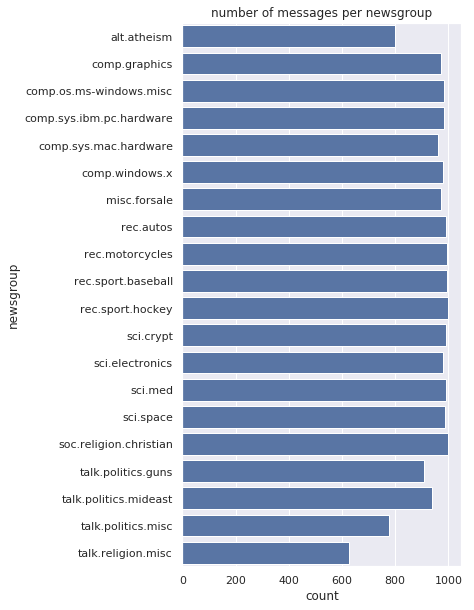

In [0]:
plt.figure(figsize=(5,10));
sns.countplot(y='newsgroup', data=data, color='b');
plt.title('number of messages per newsgroup');

data seems to be quite balanced

### functions decleration

In [0]:
# basic features
def calculate_basic_features(txt):
  
  features = pd.DataFrame()
  
  # length of txt
  features['length'] = [len(txt)]
  
  # number of dots in end of sentences
  features['n_sentences'] = [len(re.findall('\. ', txt))]
  
  # number of question marks
  features['n_questions'] = [len(re.findall('\?', txt))]
  
  # number of exclametion marks
  features['n_exclamation'] = [len(re.findall('\!', txt))]
  
  # number of white spaces
  features['n_white'] = [len(re.findall('\s', txt))]
  
  # number of new lines
  features['n_lines'] = [len(re.findall('\n', txt))]
  
  # number of digits
  
  return features

#--------------------------------------------------------------------------

# get POS for more accurate lematization
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
  
#--------------------------------------------------------------------------


# cleaning data
def clean_text(txt):
  
  porter = PorterStemmer()
  lemmatizer = WordNetLemmatizer() 
  stop_words = stopwords.words('english')
  
  email = '([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)'
  txt = re.sub(email,'', txt)


  txt = txt.lower()

  words = word_tokenize(txt)

  # remove all tokens that are not alphabetic
  words = [word for word in words if word.isalpha()]

  # remove stopwords
  words = [word for word in words if word not in stop_words]
  
  # lemmatization
  words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words] 
  
  # stemming
  words = [porter.stem(word) for word in words]
  
  # remove 3 or less letter words
  words = [word for word in words if len(word)>3]

  
  return words

#--------------------------------------------------------------------------


# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred);
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [0]:
data.head()

,newsgroup,message,message_id,label
0,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,Newsgroup: alt.atheism\ndocument_id: 49960\n,0
1,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,Newsgroup: alt.atheism\ndocument_id: 51060\n,0
2,alt.atheism,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,Newsgroup: alt.atheism\ndocument_id: 51119\n,0
3,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: R...,Newsgroup: alt.atheism\ndocument_id: 51120\n,0
4,alt.atheism,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,Newsgroup: alt.atheism\ndocument_id: 51121\n,0


# Preprocessing...

### clean data


*   lowering
*   tokenizing
*   remove non alphabetic tokens
*   remove stop words
*   remove short words
*   lematization, based on POS
*   steming








In [0]:
# clean data
clean_message = []
for i in tqdm(range(data.shape[0]), ncols=100):
  clean_message.append(clean_text(data.loc[i, 'message']))

In [0]:
data['clean_message'] = clean_message

### example of original message and the message after processing

In [0]:
print(data.loc[1000, 'message'])

From: jian@coos.dartmouth.edu (Jian Lu)
Subject: Grayscale Printer

We are interested in purchasing a grayscale printer that offers a good
resoltuion for grayscale medical images.  Can anybody give me some
recommendations on these products in the market, in particular, those
under $5000?

Thank for the advice.




In [0]:
print(data.loc[1000, 'clean_message'])

['jian', 'subject', 'grayscal', 'printer', 'interest', 'purchas', 'grayscal', 'printer', 'offer', 'good', 'resoltuion', 'grayscal', 'medic', 'imag', 'anybodi', 'give', 'recommend', 'product', 'market', 'particular', 'thank', 'advic']


In [0]:
y = data['label']
data['clean_message_join'] = data['clean_message'].str.join(sep=' ')

### train test split

the 20% will remain for pure testing.

the rest will be used for training and finetuning with Kfold CV

In [0]:
data.head()

,newsgroup,message,message_id,label,clean_message,clean_message_join
0,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,Newsgroup: alt.atheism\ndocument_id: 49960\n,0,"[mathew, subject, atheist, resourc, resourc, d...",mathew subject atheist resourc resourc decemb ...
1,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,Newsgroup: alt.atheism\ndocument_id: 51060\n,0,"[mathew, subject, introduct, atheism, introduc...",mathew subject introduct atheism introduct apr...
2,alt.atheism,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,Newsgroup: alt.atheism\ndocument_id: 51119\n,0,"[benedikt, rosenau, subject, gospel, date, art...",benedikt rosenau subject gospel date articl ch...
3,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: R...,Newsgroup: alt.atheism\ndocument_id: 51120\n,0,"[mathew, subject, univers, violat, separ, king...",mathew subject univers violat separ king becom...
4,alt.atheism,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,Newsgroup: alt.atheism\ndocument_id: 51121\n,0,"[strom, subject, princeton, match, fund, scout...",strom subject princeton match fund scout artic...


In [0]:

data_train, data_test, y_train, y_test = train_test_split(data,y, test_size=0.2, random_state=0)

# DL APPROACH

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, MaxPooling1D,  GlobalMaxPooling1D, Conv1D, Dropout, LSTM, BatchNormalization, SpatialDropout1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.callbacks import Callback, EarlyStopping
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
import warnings; warnings.filterwarnings("ignore")



Using TensorFlow backend.


In [0]:
data_train, data_test, y_train, y_test = train_test_split(data,y, test_size=0.2, random_state=0)

In [0]:
# preparing the data fro embedding

MAX_NUM_WORDS = 20000

# encoding texts to vectors  
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

tokenizer.fit_on_texts(data_train['clean_message'].values)

X_train = tokenizer.texts_to_sequences(data_train['clean_message'])
X_test = tokenizer.texts_to_sequences(data_test['clean_message'])


vocab_size = len(tokenizer.word_index) + 1

L = [len(x) for x in X_train]

# padding with zeros and cutting to fixed length

SEQUENCE_LENGTH = np.percentile(L, 90).astype(np.int)
X_train = pad_sequences(X_train, padding='post', maxlen=SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, padding='post', maxlen=SEQUENCE_LENGTH)

In [0]:
# this block generates weights for the embedding layer from pre trained word vectors (glove)
# this way this layer is not need to be trained and use this weights

EMBEDDING_DIM=100

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        

        
# tried it- it didn't impvove

In [0]:
print('vocab size:' , vocab_size )

vocab size: 52184


In [0]:
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

y_train_d = pd.get_dummies(y_train).values
y_test_d = pd.get_dummies(y_test).values

In [0]:
print(X_train.shape, y_train_d.shape)

(15062, 192) (15062, 20)




---


things I want to test:
1. number of filters
2. filters size
3. batch size
4. number of conv layers
5. pooling size
6. EMBEDDING_DIM

first, I'll try to find rough working-point by fixing all parameters except 1 and find the optimum.

then, I'll perform some sort of grid search/other optimization around that point.



In [0]:
# this function will generate model based on hyper parameters inputs
def create_model_1(num_layers, num_filters, filter_size, pool_size, EMBEDDING_DIM, batch):
  # building the model
  model = Sequential()
    
  # adding first the embedding layer
  embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM,  input_length=SEQUENCE_LENGTH)
#   embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM,  input_length=SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False )

  model.add(embedding_layer)

  # adding sets of (conv_layer, max_pooling, dropout) as much as num_layers says
  for i in range(num_layers):
    
    # conv layer
    model.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))

    
    # dropout layer
#     model.add(SpatialDropout1D(0.5))
    model.add(Dropout(0.5))

    
    # max pooling
    if i == num_layers-1:
        model.add(GlobalMaxPooling1D())
    else:
    
      model.add(MaxPooling1D(pool_size=pool_size))
    
    # dropout layer
    model.add(Dropout(0.5))
    
  # last, soft max with 20 classes
  model.add(Dense(20, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  
  return model


In [0]:
# early stoping callback
es = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=10, verbose=1, mode='max', restore_best_weights=True)

### batch size

In [0]:
# fixed parameters
num_layers = 1
num_filters = 128
filter_size = 15
pool_size = 3
EMBEDDING_DIM = 100

# changed parameter
batch_vec = [32, 64, 128, 256, 512]

score=[]
for batch in batch_vec:
  model = create_model_1(num_layers, num_filters, filter_size, pool_size, EMBEDDING_DIM, batch)

  # fitting the model
  history = model.fit(X_train, y_train_d,
                    batch_size=batch,
                    epochs=30,
                    verbose=0,
                    callbacks=[es],
                    validation_split=0.2)


  score.append(np.max(history.history['val_acc']))
  
best_batch_size = batch_vec[np.where(score==np.max(score))[0][0]]

Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping


Text(0.5, 1.0, 'val acc vs. batch_size')

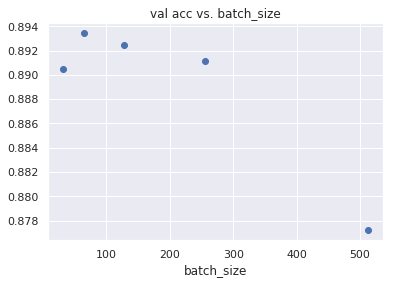

In [0]:
plt.plot(batch_vec, score,'o');
plt.xlabel('batch_size');
plt.title('val acc vs. batch_size')


### num filters

In [0]:
# fixed parameters
num_layers = 1
batch=64
filter_size = 15
pool_size = 5
EMBEDDING_DIM = 100

# changed parameter
num_filters_vec = [50, 80, 100, 120,  150]

score=[]
for num_filters in num_filters_vec:
  model = create_model_1(num_layers, num_filters, filter_size, pool_size, EMBEDDING_DIM, batch)
  

  # fitting the model
  history = model.fit(X_train, y_train_d,
                    batch_size=batch,
                    epochs=20,
                    verbose=0,
                    callbacks=[es],
                    validation_split=0.2)


  score.append(np.max(history.history['val_acc']))
  
best_num_filters = num_filters_vec[np.where(score==np.max(score))[0][0]]

Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping


num filters:  150


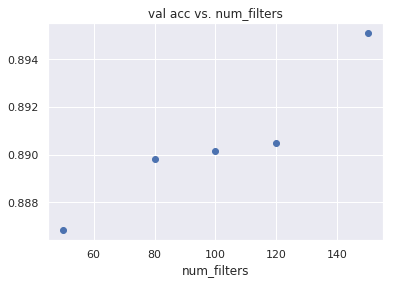

In [0]:
plt.plot(num_filters_vec, score,'o');
plt.xlabel('num_filters');
plt.title('val acc vs. num_filters');

print('num filters: ', best_num_filters)

## filter size

In [0]:
# fixed parameters
num_layers = 1
batch=64
num_filters = 120
pool_size = 5
EMBEDDING_DIM = 100

# changed parameter
filters_size_vec = [3, 5, 10, 20, 30]

score=[]
for filter_size in filters_size_vec:
  model = create_model_1(num_layers, num_filters, filter_size, pool_size, EMBEDDING_DIM, batch)
  

  # fitting the model
  history = model.fit(X_train, y_train_d,
                    batch_size=batch,
                    epochs=20,
                    verbose=0,
                    callbacks=[es],
                    validation_split=0.2)


  score.append(np.max(history.history['val_acc']))

best_filter_size = filters_size_vec[np.where(score==np.max(score))[0][0]]  

Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping


filter_size:  10


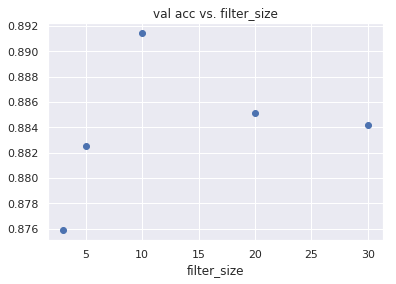

In [0]:
plt.plot(filters_size_vec, score,'o');
plt.xlabel('filter_size');
plt.title('val acc vs. filter_size');
print('filter_size: ', best_filter_size)

## EMBEDDING_DIM

In [0]:
# fixed parameters
num_layers = 1
batch=64
num_filters = 120
pool_size = 5
filter_size = 10

# changed parameter
EMBEDDING_DIM_vec = [100, 200, 300, 400, 500]

score=[]
for EMBEDDING_DIM in EMBEDDING_DIM_vec, ncols=100:
  
  model = create_model_1(num_layers, num_filters, filter_size, pool_size, EMBEDDING_DIM, batch)

  # fitting the model
  history = model.fit(X_train, y_train_d,
                    batch_size=batch,
                    epochs=20,
                    verbose=0,
                    callbacks=[es],
                    validation_split=0.2)


  score.append(np.max(history.history['val_acc']))

best_EMBEDDING_DIM = EMBEDDING_DIM_vec[np.where(score==np.max(score))[0][0]]  

best EMBEDDING_DIM:  400


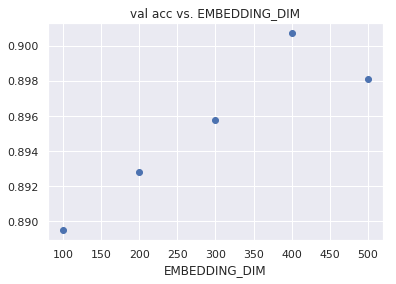

In [0]:
plt.plot(EMBEDDING_DIM_vec, score,'o');
plt.xlabel('EMBEDDING_DIM');
plt.title('val acc vs. EMBEDDING_DIM');
print('best EMBEDDING_DIM: ', best_EMBEDDING_DIM)

In [0]:
# create "black box" function for baesian optimization
# it takes all parameters i want to fine-tune, build a model, train and return the score.
# baesian optimization will maximize that score

def create_model_2(num_layers, num_filters, filter_size, pool_size, EMBEDDING_DIM, batch):  
  
  
  num_layers = int(num_layers)
  num_filters = int(num_filters)
  filter_size = int(filter_size)
  pool_size = int(pool_size)
  EMBEDDING_DIM = int(EMBEDDING_DIM)
  batch = int(batch)
  
  model = create_model_1(num_layers, num_filters, filter_size, pool_size, EMBEDDING_DIM, batch)

  es = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, verbose=1, mode='max', restore_best_weights=True)


  # fitting the model
  history = model.fit(X_train, y_train_d,
                    batch_size=batch,
                    epochs=20,
                    verbose=0,
                    callbacks=[es],
                    validation_split=0.2)


  score = np.max(history.history['val_acc'])

  return score

## Bayesian optimization

based on the working point i'll fine tune it using Bayesian optimization search

the parameters space i'll define around the working point

the bayesian process should find parameters that maximize the accuracy

In [0]:
# this is the space to search in

param_space = {'num_layers':    (1, 1),
              'num_filters':    (100, 300),
               'filter_size':   (5,30),
               'pool_size':     (3, 3),
               'EMBEDDING_DIM': (100, 300),
               'batch':         (30, 150)}

In [0]:
optimizer = BayesianOptimization(
    f=create_model_2,
    pbounds=param_space,
    random_state=0)

optimizer.maximize(init_points=30, n_iter=10)

|   iter    |  target   | EMBEDD... |   batch   | filter... | num_fi... | num_la... | pool_size |
-------------------------------------------------------------------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping
|  1        |  0.8848   |  209.8    |  115.8    |  20.07    |  209.0    |  1.0      |  3.0      |
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping
|  2        |  0.8792   |  187.5    |  137.0    |  29.09    |  176.7    |  1.0      |  3.0      |
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping
|  3        |  0.8513   |  213.6    |  141.1    |  6.776    |  117.4    |  1.0      |  3.0      |
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping
|  4        |  0.8838   |  255.6    |  134.4    |  29.47    |  259.8    |  1.0      |  3.0      |
Restoring model weights from the end of the best epoch
Epoch 00004: early stoppi

In [0]:
print('best score is:', optimizer.max['target'])

best score is: 0.896448717020771


### testing best params on test set

In [0]:
optimizer.max['params']

# {'EMBEDDING_DIM' : 260, 'batch': 57, 'filter_size': 14, 'num_filters': 285, 'num_layers': 1,'pool_size': 3}

{'EMBEDDING_DIM': 258.7395406714841,
 'batch': 56.87096256724561,
 'filter_size': 13.633792017422568,
 'num_filters': 285.6162586931182,
 'num_layers': 1.0,
 'pool_size': 3.0}

In [0]:
# taking the best iteration

best_params = optimizer.max['params']

num_layers = int(best_params['num_layers'])
num_filters = int(best_params['num_filters'])
filter_size = int(best_params['filter_size'])
pool_size = int(best_params['pool_size'])
EMBEDDING_DIM = int(best_params['EMBEDDING_DIM'])
batch = int(best_params['batch'])

model = create_model_1(num_layers, num_filters, filter_size, pool_size, EMBEDDING_DIM, batch)
init_weights = model.get_weights()

In [0]:
# i'll run the training again, with different random_states, and predict the test set
# eventually i'll take the mode of all predictions

y_pred=[] 
score=[]
es = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, verbose=1, mode='max', restore_best_weights=True)

for rand_st in range(3):
  
  K=5
  SKF = StratifiedKFold(n_splits=K, random_state=rand_st)  
  
  for train_inds, test_inds in SKF.split(X_train, y_train):
    
    model.set_weights(init_weights)

    # fitting the model
    history = model.fit(X_train[train_inds,:], y_train_d[train_inds,:],
                      batch_size=batch,
                      epochs=30,
                      verbose=1,
                      callbacks=[es],
                      validation_data=(X_train[test_inds,:], y_train_d[test_inds,:]))


    y_pred.append(np.argmax(model.predict(X_test), axis=1))

    score.append(model.evaluate(X_train[test_inds,:], y_train_d[test_inds,:])[1])

    
print(np.mean(score))
          

Train on 12040 samples, validate on 3022 samples
Epoch 1/30
12040/12040 [==============================] - 6s 488us/step - loss: 1.9422 - acc: 0.4503 - val_loss: 1.0187 - val_acc: 0.8101
Epoch 2/30
12040/12040 [==============================] - 6s 482us/step - loss: 0.4433 - acc: 0.8744 - val_loss: 0.6356 - val_acc: 0.8779
Epoch 3/30
12040/12040 [==============================] - 6s 477us/step - loss: 0.1447 - acc: 0.9611 - val_loss: 0.5279 - val_acc: 0.8799
Epoch 4/30
12040/12040 [==============================] - 6s 487us/step - loss: 0.0662 - acc: 0.9866 - val_loss: 0.4705 - val_acc: 0.8842
Epoch 5/30
12040/12040 [==============================] - 6s 490us/step - loss: 0.0397 - acc: 0.9929 - val_loss: 0.4471 - val_acc: 0.8862
Epoch 6/30
12040/12040 [==============================] - 6s 484us/step - loss: 0.0261 - acc: 0.9945 - val_loss: 0.4448 - val_acc: 0.8822
Epoch 7/30
12040/12040 [==============================] - 6s 486us/step - loss: 0.0219 - acc: 0.9953 - val_loss: 0.4326 - v

In [0]:
model.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_73 (Embedding)     (None, 192, 258)          13463472  
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 180, 285)          956175    
_________________________________________________________________
dropout_145 (Dropout)        (None, 180, 285)          0         
_________________________________________________________________
global_max_pooling1d_73 (Glo (None, 285)               0         
_________________________________________________________________
dropout_146 (Dropout)        (None, 285)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 20)                5720      
Total params: 14,425,367
Trainable params: 14,425,367
Non-trainable params: 0
_________________________________________

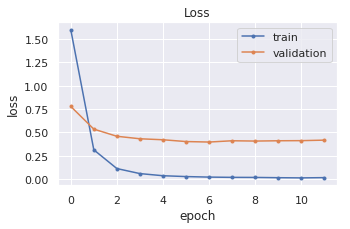

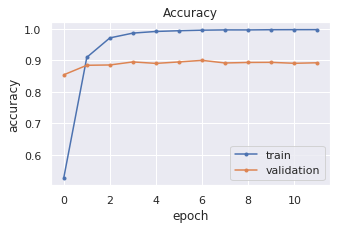

In [0]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], marker='.', label='train')
plt.plot(history.history['val_loss'], marker='.', label='validation')
plt.title('Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()


plt.figure(figsize =(5,3))
plt.plot(history.history['acc'], marker='.', label='train')
plt.plot(history.history['val_acc'], marker='.', label='validation')
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

In [0]:
y_pred_cnn = np.squeeze(stats.mode(np.vstack(y_pred), axis=0)[0])
accuracy  = np.sum((y_pred_cnn-y_test)==0)/y_test.shape[0]
f1 = f1_score(y_test, y_pred_cnn, average='macro')

print('accuracy : ', accuracy,'\nf1-score : ', f1)

accuracy :  0.9052044609665427 
f1-score :  0.9034190410032782


Confusion matrix, without normalization


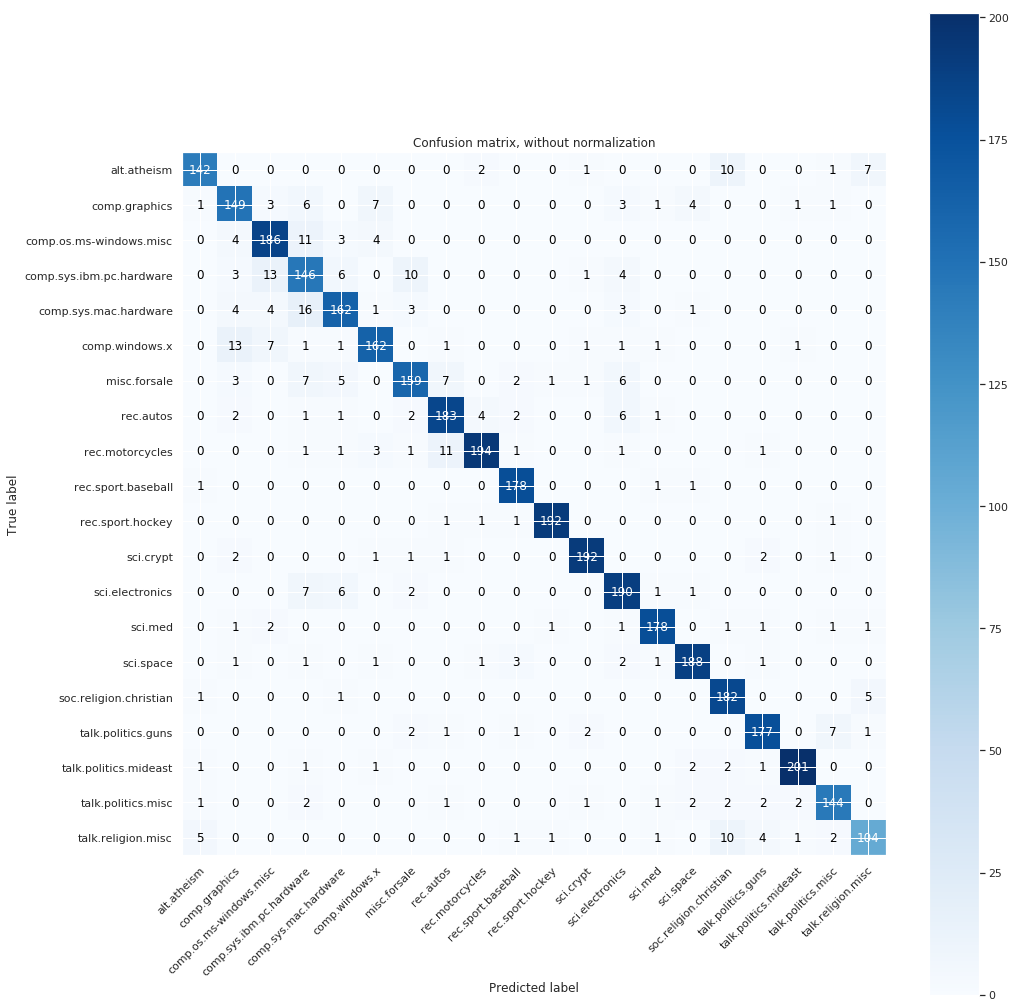

In [0]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test.values, y_pred_cnn, classes=np.array(groups_names),
                      title='Confusion matrix, without normalization',
                     normalize=False);

In [0]:
print(classification_report(y_test, y_pred_cnn,  target_names=groups_names))

                          precision    recall  f1-score   support

             alt.atheism       0.93      0.87      0.90       163
           comp.graphics       0.82      0.85      0.83       176
 comp.os.ms-windows.misc       0.87      0.89      0.88       208
comp.sys.ibm.pc.hardware       0.73      0.80      0.76       183
   comp.sys.mac.hardware       0.87      0.84      0.85       194
          comp.windows.x       0.90      0.86      0.88       189
            misc.forsale       0.88      0.83      0.86       191
               rec.autos       0.89      0.91      0.90       202
         rec.motorcycles       0.96      0.91      0.93       214
      rec.sport.baseball       0.94      0.98      0.96       181
        rec.sport.hockey       0.98      0.98      0.98       196
               sci.crypt       0.96      0.96      0.96       200
         sci.electronics       0.88      0.92      0.90       207
                 sci.med       0.96      0.95      0.95       187
         

## plans for the future...

1. more data- I think that the dataset was relativly small for complex model (~12000)
2. build LSTM model - I think it can improve the results and catch the patterns inside the text
3. try different architecures
4. add batch-normalization
5. try harder to use pre-trained word vectors (e.g, glove.6B.100d)
6. fine-tune learning rate - it seems it gets to the maximum really fast and stays there
7. combine similar groups as one class
8. put more weights on problematic classes
9. try other optimization method 